In [2]:
import gymnasium as gym
import ale_py
gym.register_envs(ale_py)
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np

from dl_helper.rl.rl_env.pong.pong_env import PongEnv

In [34]:
def show_and_save_img(obs):
    plt.figure()
    plt.imshow(obs[-1]* 255, cmap='gray')
    plt.axis('off')
    plt.show()
    img_array = (obs[-1] * 255).astype(np.uint8)
    img = Image.fromarray(img_array)
    img.save(r'C:\Users\lh\Desktop\temp\pong.png')

import numpy as np
class _PongEnv:
    def _find_ball_position(self, frame):
        """
        从单帧图像中找到球的中心位置。
        找值 217
        """
        # 查找值为 217 的所有位置
        positions = np.where(frame > 150)
        x_coords = positions[0]  # 行坐标
        y_coords = positions[1]  # 列坐标

        # 过滤 11 - 72 以外的
        bad_idxs = []
        for i, y in enumerate(y_coords):
            if y < 11 or y > 72:
                bad_idxs.append(i)
        x_coords = np.delete(x_coords, bad_idxs)
        y_coords = np.delete(y_coords, bad_idxs)
        
        if len(x_coords) == 0:
            return None, None
        elif len(x_coords) == 1:
            # 只有一个位置，返回其坐标
            return y_coords[0], x_coords[0], 
        else:
            # 有多个位置，返回 x 和 y 的均值
            mean_x = np.mean(x_coords)
            mean_y = np.mean(y_coords)
            return mean_y, mean_x

    def _find_paddle_position(self, frame):
        """
        获取挡板中心位置
        在 74 列找值 147
        """
        # 提取第 74 列
        column_74 = frame[:, 74]
        
        # 找到值为 147 的位置
        positions = np.where(column_74 == 147)[0]

        length = len(positions)
        assert length > 1

        mid_index = length // 2  # 整数除法，得到中间索引

        if length % 2 == 1:  # 奇数长度
            return (74, positions[mid_index])
        else:  # 偶数长度
            return (74, (positions[mid_index - 1] + positions[mid_index]) / 2)
            
p = _PongEnv()

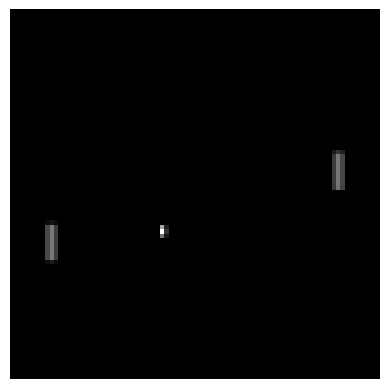

In [35]:
env = PongEnv()
obs, info = env.reset()
show_and_save_img(obs)

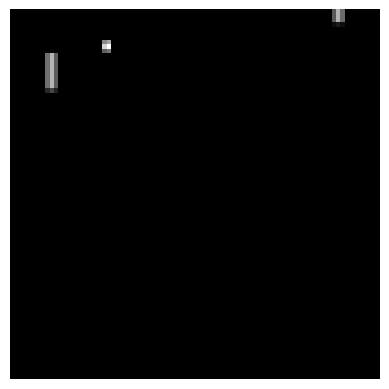

((21.5, 8.0), (74, 1))

In [189]:
# 0 不动
# 2 上移
# 3 下移
act = 2
obs, reward, terminated, truncated, info = env.step(act)
show_and_save_img(obs)

obs1 = env._get_stacked_obs()
ball_pos = p._find_ball_position(obs1[-1])
paddle_pos = p._find_paddle_position(obs1[-1])
ball_pos, paddle_pos

In [191]:
def default_reward_func(
        frame_size, 
        ball_x_0, ball_y_0, 
        ball_x_1, ball_y_1, paddle_x_1, paddle_y_1, 
        reward
    ):
    """
    默认奖励函数
    1. 计算球的落点 x,y（需要考虑上下边界反弹的情况）
    2. 计算弱点与挡板之间的距离
    3. 根据距离进行惩罚
    """
    width, height = frame_size
    
    # 计算球的速度向量
    velocity_x = ball_x_1 - ball_x_0
    velocity_y = ball_y_1 - ball_y_0
    
    # 如果球没有水平移动，直接返回原始奖励
    if velocity_x == 0:
        return reward
    
    # 计算球到右边界的时间
    time_to_right = (74 - ball_x_1) / velocity_x if velocity_x > 0 else float('inf')
    
    # 预测球到达右边界时的y坐标（考虑上下边界反弹）
    if time_to_right != float('inf'):
        # 计算球到达右边界时在y方向上的位移
        y_displacement = velocity_y * time_to_right
        
        # 计算球在到达右边界前会反弹多少次
        total_y_travel = ball_y_1 + y_displacement
        bounces = 0
        
        # 处理多次反弹的情况
        while total_y_travel < 0 or total_y_travel > height:
            if total_y_travel < 0:
                total_y_travel = -total_y_travel  # 下边界反弹
                bounces += 1
            if total_y_travel > height:
                total_y_travel = 2 * height - total_y_travel  # 上边界反弹
                bounces += 1
        
        # 最终预测的落点y坐标
        predicted_y = total_y_travel
        print(predicted_y)
        
        # 计算落点与挡板中心的距离
        distance = abs(predicted_y - paddle_y_1)
        
        # 根据距离计算惩罚（距离越大，惩罚越大）
        # 这里使用挡板高度的一半作为标准化因子
        paddle_half_height = 10  # 假设挡板高度为20，可以根据实际情况调整
        normalized_distance = min(distance / paddle_half_height, 1.0)
        
        # 距离惩罚系数，可以根据需要调整
        distance_penalty = -normalized_distance * 10
        
        # 更新奖励
        new_reward = reward + distance_penalty
        
        return new_reward
    
    # 如果球不会到达右边界（向左移动），返回原始奖励
    return reward

In [192]:
obs1 = env._get_stacked_obs()
ball_pos_0 = p._find_ball_position(obs1[0])
ball_pos = p._find_ball_position(obs1[-1])
paddle_pos = p._find_paddle_position(obs1[-1])

default_reward_func(
    (84, 84), 
    ball_pos_0[0], ball_pos_0[1], 
    ball_pos[0], ball_pos[1], 
    paddle_pos[0], paddle_pos[1], 
    0
)

76.83333333333334


-10.0